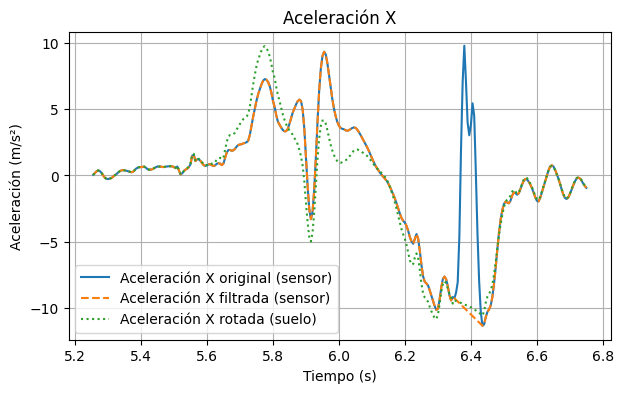

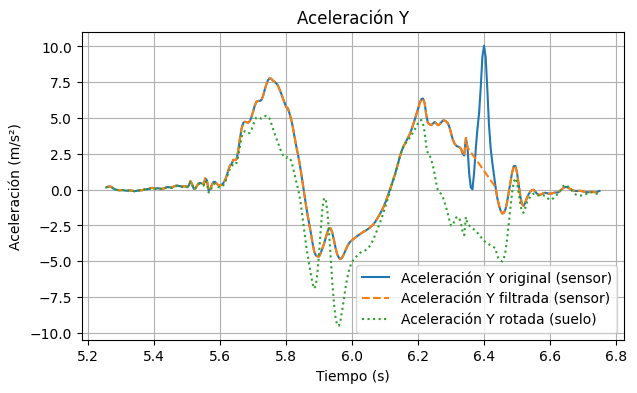

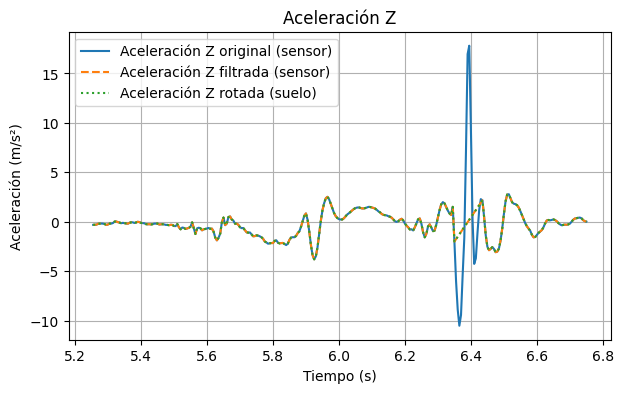

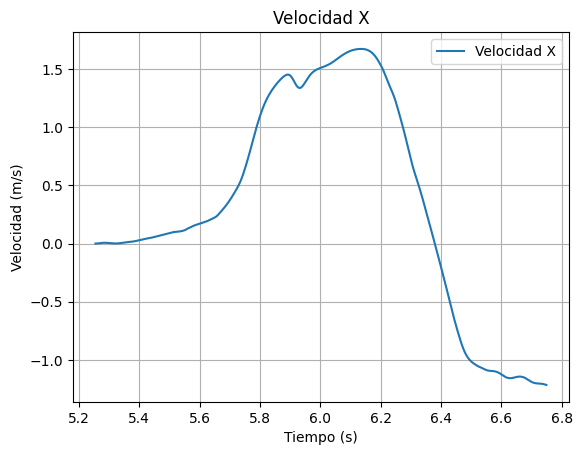

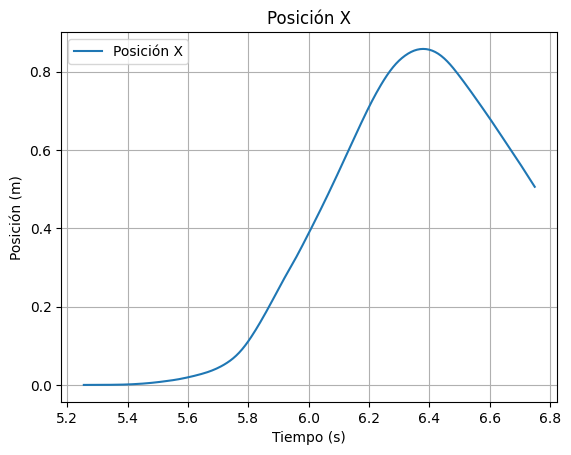

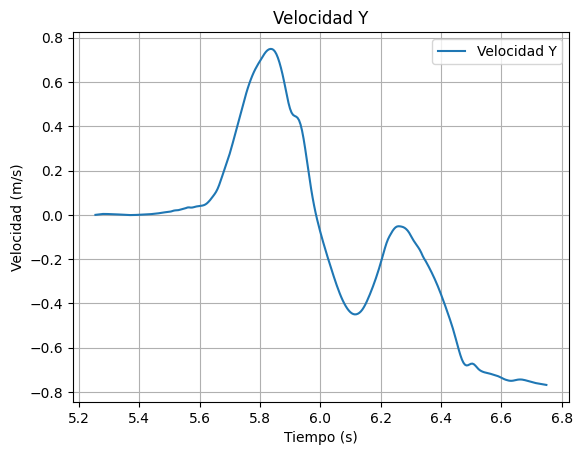

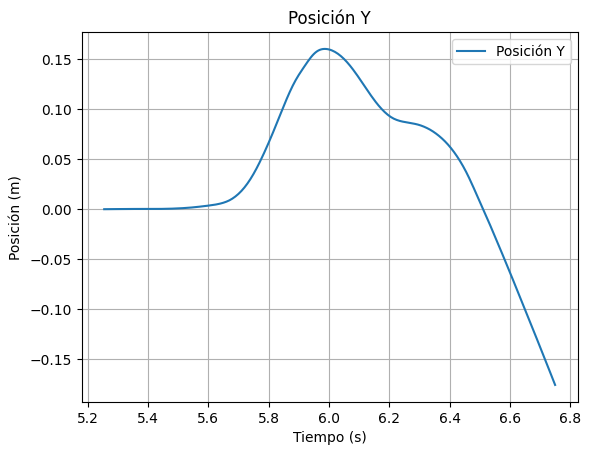

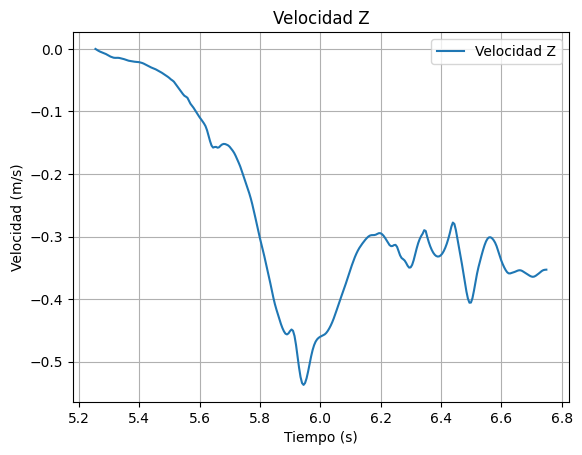

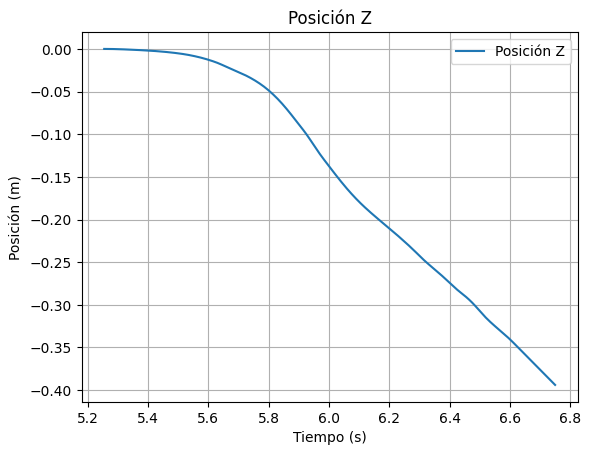

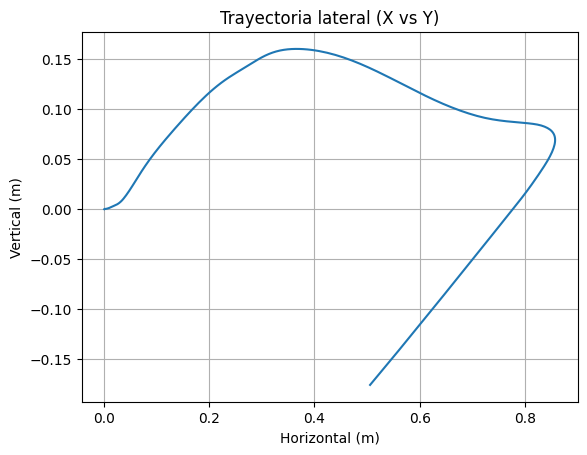

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 1) Cargar datos
acc_df = pd.read_csv('Accelerometer.csv')
gyr_df = pd.read_csv('Gyroscope.csv')

# 2) Recortar intervalo 4.5–7.5 s
t0, t1 = 5.25, 6.75
acc_df = acc_df[(acc_df['seconds_elapsed'] >= t0) & (acc_df['seconds_elapsed'] <= t1)].reset_index(drop=True)
gyr_df = gyr_df[(gyr_df['seconds_elapsed'] >= t0) & (gyr_df['seconds_elapsed'] <= t1)].reset_index(drop=True)

# 3) Interpolar giroscopio al tiempo del acelerómetro
acc_t = acc_df['seconds_elapsed'].values
gyr_t = gyr_df['seconds_elapsed'].values
gyro_z = np.interp(acc_t, gyr_t, gyr_df['z'].values)

# 4) Calcular ángulo acumulado alrededor de Z
theta_z = np.cumsum(gyro_z * np.gradient(acc_t))

# 5) Matriz de rotación 2D solo en eje Z (horizontal)
acc_sensor = acc_df[['x', 'y', 'z']].values
acc_lab = np.zeros_like(acc_sensor)

for i in range(len(acc_t)):
    c, s = np.cos(theta_z[i]), np.sin(theta_z[i])
    rot_xy = np.array([[c, -s], [s, c]])
    acc_lab[i, :2] = rot_xy @ acc_sensor[i, :2]
    acc_lab[i, 2] = acc_sensor[i, 2]  # Z no rota

# 6) Detección de picos negativos en X dentro de una ventana
x_signal = acc_sensor[:, 0]
window_start, window_end = 6.2, 6.5
window_mask = (acc_t >= window_start) & (acc_t <= window_end)
x_signal_window = x_signal[window_mask]
peaks_neg, _ = find_peaks(-x_signal_window, height=2)
global_peaks_neg = np.where(window_mask)[0][0] + peaks_neg

# 7) Interpolación entre dos últimos picos
acc_sensor_filtered = acc_sensor.copy()
if len(global_peaks_neg) >= 2:
    i0, i1 = global_peaks_neg[-2], global_peaks_neg[-1]
    for j in range(3):
        acc_sensor_filtered[i0:i1+1, j] = np.linspace(acc_sensor[i0, j], acc_sensor[i1, j], i1 - i0 + 1)

# 8) Rotar aceleraciones filtradas (solo Z)
acc_lab_filtered = np.zeros_like(acc_sensor_filtered)
for i in range(len(acc_t)):
    c, s = np.cos(theta_z[i]), np.sin(theta_z[i])
    rot_xy = np.array([[c, -s], [s, c]])
    acc_lab_filtered[i, :2] = rot_xy @ acc_sensor_filtered[i, :2]
    acc_lab_filtered[i, 2] = acc_sensor_filtered[i, 2]

# 9) Graficar aceleraciones
componentes = ['X', 'Y', 'Z']
for i, comp in enumerate(componentes):
    plt.figure(figsize=(7, 4))
    plt.plot(acc_t, acc_sensor[:, i], label=f'Aceleración {comp} original (sensor)')
    plt.plot(acc_t, acc_sensor_filtered[:, i], '--', label=f'Aceleración {comp} filtrada (sensor)')
    plt.plot(acc_t, acc_lab_filtered[:, i], ':', label=f'Aceleración {comp} rotada (suelo)')
    #if comp == 'X':
       # plt.plot(acc_t[global_peaks_neg], x_signal[global_peaks_neg], 'rx', label='Picos detectados')
    plt.title(f'Aceleración {comp}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Aceleración (m/s²)')
    plt.legend()
    plt.grid()
    plt.show()

# 10) Integración RK4
def integrate_rk4(time, signal):
    v = np.zeros_like(signal)
    for i in range(1, len(time)):
        dt = time[i] - time[i - 1]
        k1 = signal[i - 1]
        k2 = 0.5 * (signal[i - 1] + signal[i])
        k3 = k2
        k4 = signal[i]
        v[i] = v[i - 1] + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return v

# 11) Velocidad y posición
vel_lab = integrate_rk4(acc_t, acc_lab_filtered)
pos_lab = integrate_rk4(acc_t, vel_lab)

# 12) Graficar velocidades y posiciones
for i, comp in enumerate(componentes):
    plt.figure()
    plt.plot(acc_t, vel_lab[:, i], label=f'Velocidad {comp}')
    plt.title(f'Velocidad {comp}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Velocidad (m/s)')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.plot(acc_t, pos_lab[:, i], label=f'Posición {comp}')
    plt.title(f'Posición {comp}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Posición (m)')
    plt.legend()
    plt.grid()

# 13) Trayectoria lateral con eje X como horizontal
plt.figure()
plt.plot(pos_lab[:, 0], pos_lab[:, 1])
plt.title('Trayectoria lateral (X vs Y)')
plt.xlabel('Horizontal (m)')
plt.ylabel('Vertical (m)')
plt.grid()
plt.show()
